In [1]:
# TODO:
# - Add a second portion to the notebook that does the same thing, but uses
#   different activation functions indicated by different colors in loss plots

In [2]:
import math
from typing import Iterator, List, Optional, Tuple

import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

from phd.feature_search.core.models import ACTIVATION_MAP, LTU
from phd.feature_search.core.tasks import NonlinearGEOFFTask

%matplotlib inline

In [3]:
hydra.initialize(config_path='../conf')

/tmp/ipykernel_56020/1376431350.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


hydra.initialize()

In [4]:
def standardize_targets(
    targets: torch.Tensor,
    cumulant_mean: float,
    cumulant_square_mean: float,
    cumulant_gamma: float,
    step: int,
) -> torch.Tensor:
    """Standardize targets using a running mean and variance."""
    cumulant_mean = cumulant_gamma * cumulant_mean + (1 - cumulant_gamma) * targets.mean()
    cumulant_square_mean = cumulant_gamma * cumulant_square_mean + (1 - cumulant_gamma) * targets.square().mean()
    bias_correction = 1 / (1 - cumulant_gamma ** (step + 1))
    curr_mean = cumulant_mean * bias_correction
    curr_square_mean = cumulant_square_mean * bias_correction
    std_dev = torch.max(torch.tensor(0.0), curr_square_mean - curr_mean.square()).sqrt()
    std_dev = 1 if std_dev < 1e-6 else std_dev
    targets = (targets - curr_mean) / std_dev
    return targets, cumulant_mean, cumulant_square_mean

In [5]:
class ZeroMaskedGradients(torch.autograd.Function):
    """Custom autograd function to zero out gradients for masked weights."""
    
    @staticmethod
    def forward(ctx, weights: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        ctx.save_for_backward(mask)
        return weights

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None]:
        mask, = ctx.saved_tensors
        return grad_output * mask, None


class ParallelLinear(nn.Module):
    """A linear layer that applies multiple weight matrices in parallel to the same input.
    
    Args:
        in_features: Size of each input sample
        out_features: Size of each output sample
        n_parallel: Number of parallel weight matrices
        bias: If True, adds a learnable bias to the output
    """
    
    def __init__(
        self,
        in_features: int,
        out_features: int,
        n_parallel: int,
        bias: bool = True,
        sparsity: float = 0,
    ) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_parallel = n_parallel
        self.sparsity = sparsity
        
        self.weight = nn.Parameter(torch.empty(n_parallel, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(n_parallel, out_features))
        else:
            self.register_parameter('bias', None)
        
        if self.sparsity > 0:
            sparsity_mask = (torch.rand_like(self.weight) > sparsity).float()
            self.register_buffer('sparsity_mask', sparsity_mask)
            self.weight = self.weight * self.sparsity_mask
            
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        """Initialize weights using the same strategy as nn.Linear."""
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in = self.weight.size(1)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (in_features,) or (n_parallel, in_features)
            
        Returns:
            Output tensor of shape (n_parallel, out_features)
        """
        # Reshape input to (n_parallel, in_features, 1)
        if x.dim() == 1:
            x = x.unsqueeze(0).unsqueeze(2).expand(self.n_parallel, -1, 1)
        elif x.dim() == 2:
            x = x.unsqueeze(2)
        else:
            raise ValueError(f'Input tensor must have 1 or 2 dimensions, got {x.dim()}')
        
        if self.sparsity > 0:
            weight = self.weight * self.sparsity_mask
            weight = ZeroMaskedGradients.apply(weight, self.sparsity_mask)
        else:
            weight = self.weight
        
        # Apply parallel matrix multiplication
        output = torch.bmm(weight, x)
        output = output.squeeze(2)
        
        if self.bias is not None:
            output += self.bias
        
        return output


class SplitActivation(nn.Module):
    def __init__(self):
        """Splits input into 5 groups and applies different activations to each."""
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh() 
        self.sigmoid = nn.Sigmoid()
        self.ltu = LTU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get dimensions and calculate split points
        n_features = x.shape[-1]
        split_size = n_features // 5
        remainder = n_features % 5
        
        # Apply different activations to each section
        out = torch.empty_like(x)
        
        # First section: ReLU
        end1 = split_size + (1 if remainder > 0 else 0)
        out[..., :end1] = self.relu(x[..., :end1])
        
        # Second section: Tanh
        end2 = end1 + split_size + (1 if remainder > 1 else 0)
        out[..., end1:end2] = self.tanh(x[..., end1:end2])
        
        # Third section: Sigmoid
        end3 = end2 + split_size + (1 if remainder > 2 else 0)
        out[..., end2:end3] = self.sigmoid(x[..., end2:end3])
        
        # Fourth section: LTU (Linear Threshold Unit)
        end4 = end3 + split_size + (1 if remainder > 3 else 0)
        out[..., end3:end4] = self.ltu(x[..., end3:end4])
        
        # Fifth section: Sin
        out[..., end4:] = torch.sin(x[..., end4:])
        
        return out


ACTIVATION_MAP['split'] = SplitActivation


class ParallelMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_parallel: int,
        n_layers: int,
        hidden_dim: int,
        activation: str = 'tanh',
        sparsity: float = 0,
    ) -> None:
        """A simplified MLP that uses parallel linear layers to get multiple outputs.
        
        Args:
            input_dim: Number of input features
            output_dim: Number of output features per parallel network
            n_parallel: Number of parallel networks
            n_layers: Number of layers (including output)
            hidden_dim: Size of hidden layers
            activation: Activation function ('relu', 'tanh', 'sigmoid', 'ltu', or 'split')
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_parallel = n_parallel
        activation_cls = ACTIVATION_MAP[activation]
        
        # Build layers
        self.layers = nn.ModuleList()
        if n_layers == 1:
            self.layers.append(ParallelLinear(input_dim, output_dim, n_parallel, bias=False))
        else:
            self.layers.append(ParallelLinear(input_dim, hidden_dim, n_parallel, bias=False))
            self.layers.append(activation_cls())
            self.layers.append(nn.LayerNorm(hidden_dim))
            for _ in range(n_layers - 2):
                self.layers.append(ParallelLinear(hidden_dim, hidden_dim, n_parallel, bias=False))
                self.layers.append(activation_cls())
                self.layers.append(nn.LayerNorm(hidden_dim))
            self.layers.append(ParallelLinear(hidden_dim, output_dim, n_parallel, bias=False))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (input_dim,)
            
        Returns:
            Output tensor of shape (n_parallel, output_dim)
        """
        param_inputs = {}
        for i in range(0, len(self.layers) - 2, 3):
            param_inputs[self.layers[i].weight] = x
            x = self.layers[i](x) # Linear layer
            x = self.layers[i + 1](x) # Activation
            x = self.layers[i + 2](x) # Layer norm

        param_inputs[self.layers[-1].weight] = x
        return self.layers[-1](x), param_inputs


## Training and plotting functions

In [13]:
def train_model(
    model: torch.nn.Module,
    task_iterator: Iterator,
    optimizer: torch.optim.Optimizer,
    n_steps: int,
    device: str,
    standardize_cumulants: bool = False,
    output_mean: float = 0.0,
    output_std: float = 1.0,
) -> tuple[np.ndarray, list, float, float]:
    """Trains model for specified number of steps and returns training history.
    
    Args:
        model: Neural network model to train
        task_iterator: Iterator yielding training data
        optimizer: Optimizer for model parameters
        n_steps: Number of training steps
        device: Device to run model on
        standardize_cumulants: Whether to standardize targets
        cumulant_mean: Running mean for standardization
        cumulant_square_mean: Running square mean for standardization 
        cumulant_gamma: Decay factor for running means
        
    Returns:
        Tuple containing:
        - Array of loss history
        - List of target history
        - Final cumulant mean
        - Final cumulant square mean
    """
    loss_history = []
    target_history = []

    for step in tqdm(range(n_steps)):
        # Generate batch of data
        inputs, targets = next(task_iterator)
        inputs, targets = inputs.to(device), targets.to(device)

        features = inputs.squeeze(0)
        
        if standardize_cumulants:
            targets = (targets - output_mean) / output_std
        target_history.append(targets.cpu().detach().numpy())

        # Forward pass
        outputs, param_inputs = model(features)
        outputs = outputs.squeeze(1)
        losses = (outputs - targets.squeeze()).pow(2)
        loss = losses.sum()
        loss_history.append(losses.cpu().detach().numpy())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_history = np.stack(loss_history, axis=1)
    return loss_history, target_history

In [14]:
def plot_loss_percentiles(loss_history: np.ndarray, n_bins: int = 30, stat_indices: Optional[List[int]] = None) -> List[int]:
    """Plot loss curves for different percentiles of performance.
    
    Creates two plots showing the binned loss curves for different percentiles:
    1. With default y-axis limits
    2. With y-axis limits between 0 and 1
    
    Args:
        loss_history: Array of shape (n_samples, n_steps) containing loss values
        n_bins: Number of bins to use for averaging loss curves
        stat_indices: Optional list of indices to plot. If None, indices are selected based on percentiles.
        
    Returns:
        List of indices for the statistic runs in sorted order (best to worst)
    """
    # Get indices sorted by average loss
    avg_losses = loss_history.mean(axis=1)
    sorted_indices = np.argsort(avg_losses)

    if stat_indices is None:
        # Extract indices at different percentiles 
        n_samples = len(sorted_indices)
        best_idx = sorted_indices[0]
        p10_idx = sorted_indices[int(0.1 * n_samples)]
        p25_idx = sorted_indices[int(0.25 * n_samples)]
        p50_idx = sorted_indices[int(0.5 * n_samples)]
        p75_idx = sorted_indices[int(0.75 * n_samples)]
        p90_idx = sorted_indices[int(0.9 * n_samples)]
        worst_idx = sorted_indices[-1]

        # Store indices for return value
        stat_indices = [best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]

    # Create bins and truncate history if needed
    history_length = len(loss_history[0])
    bin_size = history_length // n_bins
    truncated_length = bin_size * n_bins
    if truncated_length < history_length:
        loss_history = loss_history[:, :truncated_length]
    x_points = np.arange(n_bins) * bin_size

    # Compute binned averages for all samples
    n_samples = len(loss_history)
    reshaped_all = loss_history.reshape(n_samples, n_bins, bin_size)
    binned_losses_all = reshaped_all.mean(axis=2)

    # Compute binned averages for selected percentiles
    selected_losses = loss_history[stat_indices]
    reshaped = selected_losses.reshape(len(stat_indices), n_bins, bin_size)
    binned_losses = reshaped.mean(axis=2)
    
    # Create color palette that transitions from blue to red
    colors = list(sns.color_palette('RdBu_r', n_colors=7))
    colors[3] = (0.5, 0.5, 0.5)

    # Plot with default y limits
    plt.figure()
    
    # Plot all lines in light gray first
    for i in range(n_samples):
        if i not in set(stat_indices):
            plt.plot(
                x_points, binned_losses_all[i], color='lightgray', alpha=0.45, linewidth=0.8, zorder=1)
    
    # Plot percentile lines on top
    labels = ['Best', '10%', '25%', '50%', '75%', '90%', 'Worst']
    for i, (loss, color) in enumerate(zip(binned_losses, colors)):
        label = labels[i] if labels else f'Run {stat_indices[i]}'
        sns.lineplot(x=x_points, y=loss, color=color, label=label, zorder=2)
    plt.legend()
    plt.show()
    
    return stat_indices

In [15]:
# Switch to using debiased version after noticing some problems and reading this paper: https://arxiv.org/pdf/2405.01012
# The new method was originally proposed in this stats paper: https://arxiv.org/pdf/1310.2926
# Code adapted from: https://github.com/Alxmrphi/correcting_CKA_alignment

def gram_linear(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
      x: A num_examples x num_features matrix of features.

    Returns:
      A num_examples x num_examples Gram matrix of examples.
    """
    return x.astype(np.float64).dot(x.T.astype(np.float64))

def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
      gram: A num_examples x num_examples symmetric matrix.
      unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
        estimate of HSIC. Note that this estimator may be negative.

    Returns:|
      A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError('Input must be a symmetric matrix.')
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram

def cka(X, Y, debiased=True):
    """Compute CKA.

    Args:
      X: A num_examples x example_dim matrix.
      Y: A num_examples x example_dim matrix.
      debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
      The value of CKA between X and Y.
    """
    gram_x = gram_linear(X)
    gram_y = gram_linear(Y)

    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)

def pairwise_cka_matrix(features):
    """
    Compute a pairwise CKA matrix for feature representations across samples.
    
    Args:
        features (np.ndarray): Array of shape (n_samples, n_vectors, vector_dim).
    
    Returns:
        np.ndarray: Pairwise CKA matrix of shape (n_vectors, n_vectors).
    """
    n_vectors = features.shape[1]
    cka_matrix = np.zeros((n_vectors, n_vectors))

    for i in range(n_vectors):
        for j in range(i, n_vectors):
            X = features[:, i, :]  # Shape: (n_samples, vector_dim)
            Y = features[:, j, :]  # Shape: (n_samples, vector_dim)

            cka_value = cka(X, Y)
            
            cka_matrix[i, j] = cka_value
            cka_matrix[j, i] = cka_value  # Symmetric matrix

    return cka_matrix


def plot_cka(model, task_iterator, device, layer_idx=-1, n_samples=300):
    representations = [] # (n_samples, n_parallel, n_features)

    # Generate batch of feature samples
    for i in range(n_samples):
        inputs = next(task_iterator)[0]
        features = inputs.squeeze(0).to(device)
        with torch.no_grad():
            outputs, param_inputs = model(features)
        representations.append(param_inputs[model.layers[layer_idx * 3 + 2].weight])

    representations = torch.stack(representations, axis=0)
    representations = representations.cpu().detach().numpy()

    n_reprs = representations.shape[1]

    # Compute Linear CKA matrix
    linear_cka_matrix = pairwise_cka_matrix(representations)
    sns.heatmap(linear_cka_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.title('Linear CKA matrix')
    plt.show()

    mean_linear_cka = np.tril(linear_cka_matrix, k=-1).sum() / (n_reprs * (n_reprs - 1) / 2)
    print(f'Mean Linear CKA: {mean_linear_cka:.4f}')

## Experiment Setup

In [16]:
config = hydra.compose(
    config_name = 'sparse_binary_geoff',
    overrides = [
        'device=cuda',
        
        # Task params
        'task.n_features=10',
        'task.hidden_dim=5',
        'task.sparsity=0.0',
        'task.n_layers=2',
        
        # Model params
        'model.output_dim=1',
        'model.n_layers=10',
        'model.hidden_dim=100',
        'model.activation=relu',
        '+model.n_parallel=50',
        '+model.sparsity=0.0',
        
        # Training params
        'train.learning_rate=0.00003',
        'train.weight_decay=0.0',
        'train.standardize_cumulants=True',
    ]
)

In [17]:
# TODO: Consider not using binary weights.
task = NonlinearGEOFFTask(
    n_features = config.task.n_features,
    flip_rate = config.task.flip_rate,
    n_layers = config.task.n_layers,
    n_stationary_layers = config.task.n_stationary_layers,
    hidden_dim = config.task.hidden_dim if config.task.n_layers > 1 else 0,
    weight_scale = config.task.weight_scale,
    activation = config.task.activation,
    sparsity = config.task.sparsity,
    weight_init = config.task.weight_init,
    input_mean_range = (0.5, 1.5),
    input_std_range = (0.5, 1.0),
)

task_iterator = task.get_iterator(1)

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: -0.2550, output std: 0.8580


In [18]:
# Initialize model and optimizer
model = ParallelMLP(
    input_dim = config.task.n_features,
    output_dim = config.model.output_dim,
    n_parallel = config.model.n_parallel,
    n_layers = config.model.n_layers,
    hidden_dim = config.model.hidden_dim,
    activation = config.model.activation,
    sparsity = config.model.sparsity,
).to(config.device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Effectively RMSProp
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config.train.learning_rate,
    betas = (0.0, 0.999),
    weight_decay = config.train.weight_decay,
)

Total parameters: 4,056,800


## CKA pre-training

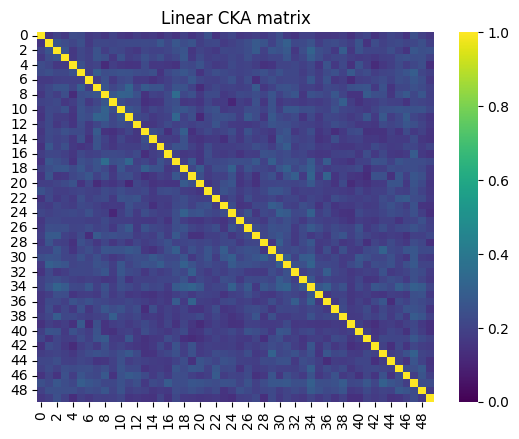

Mean Linear CKA: 0.2047


In [19]:
plot_cka(model, task_iterator, device=config.device, layer_idx=-1)

## Train

In [20]:
phase_one_steps = 40000
phase_two_steps = 5000

frac_weight_change = 0.2

loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_one_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
stat_indices = plot_loss_percentiles(loss_history)

  2%|▏         | 706/40000 [00:08<07:32, 86.93it/s] 


KeyboardInterrupt: 

## CKA post-training

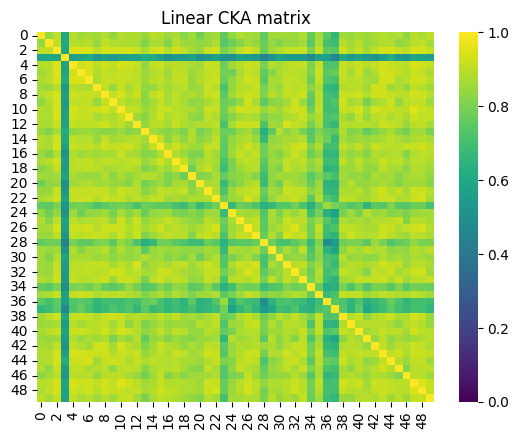

Mean Linear CKA: 0.8379


In [20]:
plot_cka(model, task_iterator, config.device, layer_idx=-1)

### Change target function

In [14]:
# modify_layer_idx = -1

# # Get total number of weights
# final_layer_weights = task.weights[modify_layer_idx]
# n_weights = final_layer_weights.numel()

# # Calculate number of weights to flip (20%)
# n_flip = int(0.2 * n_weights)

# # Get random indices to flip
# flip_indices = torch.randperm(n_weights)[:n_flip]

# orig_shape = task.weights[modify_layer_idx].shape
# with torch.no_grad():
#     task.weights[modify_layer_idx].view(-1)[flip_indices] *= -1

# outputs = []
# for _ in range(5000):
#     inputs, targets = next(task_iterator)
#     outputs.append(targets)

# outputs = torch.stack(outputs).squeeze()
# output_mean = outputs.mean().item()
# output_std = outputs.std().item()

# print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

### Change input distribution

In [21]:
# n_features = task.n_features

# task.input_mean = torch.zeros(task.n_features)
# task.input_std = torch.ones(task.n_features)

# Sample mean and std values uniformly from specified ranges
task.input_mean.uniform_(-1.5, -0.5, generator=task.generator)
task.input_std.uniform_(0.5, 1.0, generator=task.generator)

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: 0.1760, output std: 1.0052


## Train Phase 2

100%|██████████| 5000/5000 [00:26<00:00, 191.72it/s]


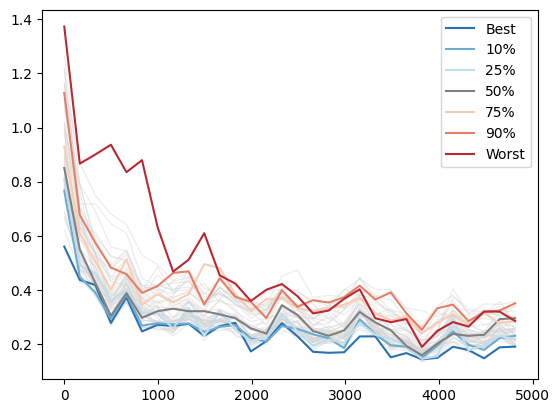

In [22]:
loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_two_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
p2_stat_indices = plot_loss_percentiles(loss_history)

### Losses plotted w/ phase 1 stats

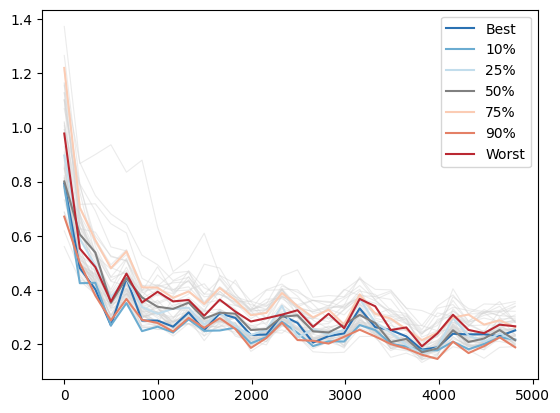

In [24]:
plot_loss_percentiles(loss_history, stat_indices=stat_indices);

# Split activation experiments

## Plotting functions

In [30]:
def plot_loss_percentiles_by_activation(loss_history: np.ndarray, activations: List[str], n_bins: int = 30):
    """Plot loss curves for different percentiles of performance.
    
    Creates two plots showing the binned loss curves for different percentiles:
    1. With default y-axis limits
    2. With y-axis limits between 0 and 1
    
    Args:
        loss_history: Array of shape (n_samples, n_steps) containing loss values
        activations: Activation for each index model in the parallel MLP
        n_bins: Number of bins to use for averaging loss curves
    """
    assert len(loss_history) == len(activations)

    # Create bins and truncate history if needed
    history_length = len(loss_history[0])
    bin_size = history_length // n_bins
    truncated_length = bin_size * n_bins
    if truncated_length < history_length:
        loss_history = loss_history[:, :truncated_length]
    x_points = np.arange(n_bins) * bin_size

    # Compute binned averages for all samples
    n_samples = len(loss_history)
    reshaped_all = loss_history.reshape(n_samples, n_bins, bin_size)
    binned_losses_all = reshaped_all.mean(axis=2)
    
    # Create color mapping for each activation type
    unique_activations = list(set(activations))
    activation_colors = dict(zip(unique_activations, sns.color_palette('deep', len(unique_activations))))

    # Plot with default y limits
    plt.figure()
    
    # Plot all lines colored by activation type
    for i in range(n_samples):
        plt.plot(
            x_points, 
            binned_losses_all[i], 
            color=activation_colors[activations[i]], 
            alpha=0.45, 
            linewidth=0.8, 
            zorder=1
        )
    
    # Add legend with activation types
    for act, color in activation_colors.items():
        plt.plot([], [], color=color, label=act, alpha=0.8, linewidth=2)
    
    plt.legend()
    plt.show()
    
    return stat_indices

## Setup

In [26]:
config = hydra.compose(
    config_name = 'sparse_binary_geoff',
    overrides = [
        'device=cuda',
        
        # Task params
        'task.n_features=10',
        'task.hidden_dim=5',
        'task.sparsity=0.0',
        'task.n_layers=2',
        
        # Model params
        'model.output_dim=1',
        'model.n_layers=10',
        'model.hidden_dim=100',
        'model.activation=split',
        '+model.n_parallel=50',
        '+model.sparsity=0.0',
        
        # Training params
        'train.learning_rate=0.00003',
        'train.weight_decay=0.0',
        'train.standardize_cumulants=True',
    ]
)

# TODO: Consider not using binary weights.
task = NonlinearGEOFFTask(
    n_features = config.task.n_features,
    flip_rate = config.task.flip_rate,
    n_layers = config.task.n_layers,
    n_stationary_layers = config.task.n_stationary_layers,
    hidden_dim = config.task.hidden_dim if config.task.n_layers > 1 else 0,
    weight_scale = config.task.weight_scale,
    activation = config.task.activation,
    sparsity = config.task.sparsity,
    weight_init = config.task.weight_init,
    input_mean_range = (0.5, 1.5),
    input_std_range = (0.5, 1.0),
)

task_iterator = task.get_iterator(1)

outputs = []
for _ in range(5000):
    inputs, targets = next(task_iterator)
    outputs.append(targets)

outputs = torch.stack(outputs).squeeze()
output_mean = outputs.mean().item()
output_std = outputs.std().item()

print(f'Output mean: {output_mean:.4f}, output std: {output_std:.4f}')

Output mean: -0.1070, output std: 0.7083


In [27]:
# Initialize model and optimizer
model = ParallelMLP(
    input_dim = config.task.n_features,
    output_dim = config.model.output_dim,
    n_parallel = config.model.n_parallel,
    n_layers = config.model.n_layers,
    hidden_dim = config.model.hidden_dim,
    activation = config.model.activation,
    sparsity = config.model.sparsity,
).to(config.device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Effectively RMSProp
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config.train.learning_rate,
    betas = (0.0, 0.999),
    weight_decay = config.train.weight_decay,
)

Total parameters: 4,056,800


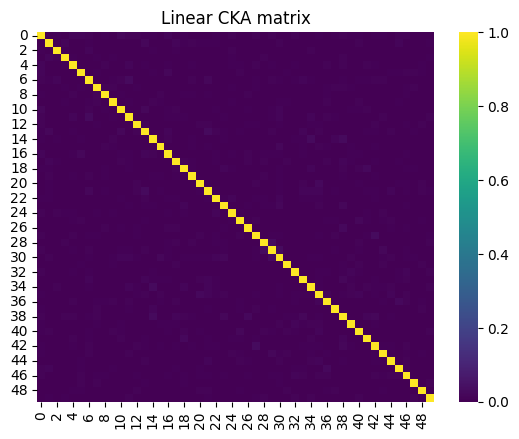

Mean Linear CKA: 0.0015


In [28]:
plot_cka(model, task_iterator, device=config.device, layer_idx=-1)

100%|██████████| 10000/10000 [02:45<00:00, 60.55it/s]


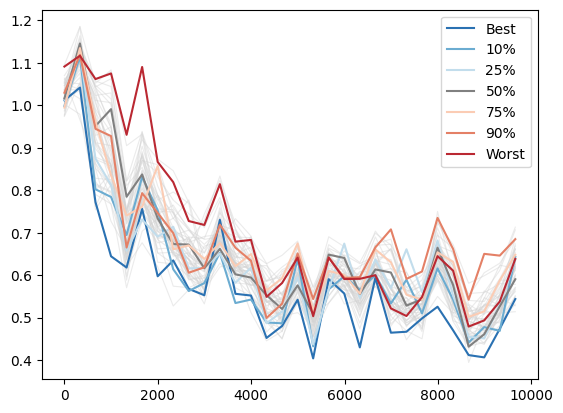

In [29]:
phase_one_steps = 10000
phase_two_steps = 5000

frac_weight_change = 0.2

loss_history, target_history = train_model(
    model, task_iterator, optimizer, phase_one_steps, config.device,
    config.train.standardize_cumulants, output_mean, output_std,
)
stat_indices = plot_loss_percentiles(loss_history)

In [32]:
unique_activations = np.array(['relu', 'tanh', 'sigmoid', 'ltu', 'sin'])
activations = unique_activations.repeat(np.ceil(model.n_parallel / len(unique_activations)))[:model.n_parallel]
plot_loss_percentiles_by_activation(loss_history, activations)

array(['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu',
       'relu', 'relu', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh',
       'tanh', 'tanh', 'tanh', 'tanh', 'sigmoid', 'sigmoid', 'sigmoid',
       'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid',
       'sigmoid', 'ltu', 'ltu', 'ltu', 'ltu', 'ltu', 'ltu', 'ltu', 'ltu',
       'ltu', 'ltu', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin', 'sin',
       'sin', 'sin', 'sin'], dtype='<U7')